Import required libraries.

In [75]:
# import data science libraries
import pandas as pd
import numpy as np

# import scikit-learn preprocessing functions
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import findiff diffusion models
from MLPSynthesizer import MLPSynthesizer
from BaseDiffuser import BaseDiffuser
from findiff_modules import train_epoch, decode_sample, generate_samples

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile

# import visualisation libraries
import seaborn as sns

Init and set experiment parameters. 

In [76]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 3000

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

Set random seed values.

In [77]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [78]:
# set data path
data_url = 'https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip'

# download the file
response = requests.get(data_url)

# determine the zip file
zip_file = ZipFile(BytesIO(response.content))

# extract the zip file
zip_file.extractall('data')

# read the UCI credit card dataset
train_raw = pd.read_excel('data/default of credit card clients.xls', skiprows=[0])

Inspect the top 10 rows and attribute names of the dataset retreived.

In [79]:
# display top 10 rows
train_raw.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [80]:
# display attribute names 
train_raw.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Set numerical and categorical dataset attributes. 

In [81]:
# determine categorical attributes
cat_attrs = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY0', 'PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']

# determine numerical attributes
num_attrs = ['LIMITBAL', 'BILLAMT1', 'BILLAMT2', 'BILLAMT3', 'BILLAMT4', 'BILLAMT5', 'BILLAMT6',
             'PAYAMT1', 'PAYAMT2', 'PAYAMT3', 'PAYAMT4', 'PAYAMT5', 'PAYAMT6']

Pre-process dataset attributes.

In [82]:
# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

Set dataset label.

In [83]:
# extract label
label = train_raw['default payment next month']

Determine the training data.

In [84]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

Transform the numerical attributes.

In [85]:
# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

Transform the categorical attributes.

In [86]:
# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder 
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

Convert numerical and categorical attributes as well as the labels to tensors.

In [87]:
# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

Convert dataset to tensor dataset. 

In [88]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [89]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Initialize and train the FinDiff model

In [90]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [91]:
# initialize the FinDiff synthesizer model 
synthesizer = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [92]:
# initialize the FinDiff diffuser model
diffuser = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler
)

Init optimizer, scheduler and loss function.

In [93]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

In [96]:
# init epoch training losses
epoch_losses = []

# init the training progress bar 
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:
        
        # set synthesizer model in training mode
        synthesizer.train()

        # sample timestamps t
        timesteps = diffuser.sample_timesteps(n=batch_cat.shape[0])

        # get cat embeddings
        batch_cat_emb = synthesizer.embed_categorical(x_cat=batch_cat)
        # concat cat & num
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add noise
        batch_noise_t, noise_t = diffuser.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct forward encoder/decoder pass
        predicted_noise = synthesizer(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute train loss
        batch_loss = loss_fnc(
            input=noise_t,
            target=predicted_noise,
        )

        # reset encoder and decoder gradients
        optimizer.zero_grad()

        # run error back-propagation
        batch_loss.backward()

        # optimize encoder and decoder parameters
        optimizer.step()

        # collect rec error losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # average of rec errors
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate according to the scheduler
    lr_scheduler.step()

    # collect training epoch loss
    epoch_losses.append({**base_params, **batch_losses_mean})

    # prepare training epoch progress bar update
    desc_losses = 'FinDiff training | '.join([f'{name}: {loss:.3f}' for name, loss in epoch_losses.items()])

    # update training epoch progress bar
    pbar.set_description(desc_info + ' | ' + desc_losses)


  0%|                                                                 | 0/3000 [00:07<?, ?it/s]


TypeError: 'numpy.float32' object is not a mapping

# Sampling

In [ ]:
# generate new samples
generated_samples = generate_samples(
    synthesizer=synthesizer,
    diffuser=diffuser,
    encoded_dim=encoded_dim,
    last_diff_step=exp_params['diffusion_steps'],
    label=label_torch
)
# decode generated samples, i.e. numeric upscaling + categorical inverse encoding
generated_samples_df = decode_sample(
    sample=generated_samples,
    cat_dim=cat_dim,
    n_cat_emb=exp_params['n_cat_emb'],
    num_attrs=num_attrs,
    cat_attrs=cat_attrs,
    num_scaler=num_scaler,
    vocab_per_attr=vocab_per_attr,
    label_encoder=label_encoder,
    synthesizer=synthesizer
)

# Evaluate generated data

In [11]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=generated_samples_df,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 253/253 [00:03<00:00, 65.11it/s] 

Overall Quality Score: 89.0%

Properties:
- Column Shapes: 96.34%
- Column Pair Trends: 81.66%


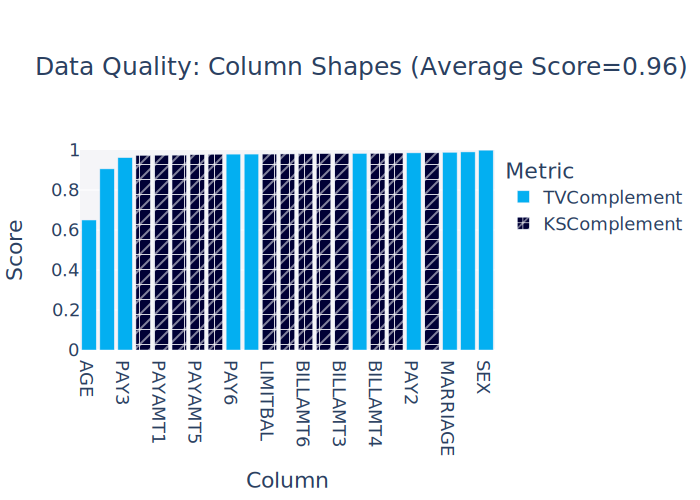

In [21]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show(renderer="svg")

In [ ]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig